In [1]:
# Import the required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
#warnings.filterwarnings('ignore')

In [2]:
# set the display to 100 rows and columns

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',100)

In [3]:
# Importing the Dataset 

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [4]:
train_df.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,2,Yes,Yes,No,Yes,Yes,Drum,1197,4,Automatic,5,Electric,4.8,3995,1735,1515,1335,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


In [5]:
test_df.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating
0,ID58593,0.341732,0.00,0.586538,C3,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0
1,ID58594,0.307241,0.13,0.442308,C8,8794,1,B2,M6,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,K Series Dual jet,2,No,Yes,No,Yes,No,Drum,1197,4,Manual,5,Electric,4.8,3845,1735,1530,1335,Yes,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2
2,ID58595,0.327924,0.12,0.451923,C8,8794,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2
3,ID58596,0.782654,0.01,0.461538,C5,34738,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0
4,ID58597,1.233404,0.02,0.634615,C5,34738,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0


## Data Insights and EDA

In [6]:
# Printing the shape of the train and test dataset

train_df.shape, test_df.shape

((58592, 44), (39063, 43))

In [7]:
# View the summary of the dataset

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

### Comments:

- This info reflects that the dataset has no null values.
- There are 28 Categorical features and 16 numerical features.

In [8]:
# let's check for missing values:

train_df.isnull().sum()

policy_id                           0
policy_tenure                       0
age_of_car                          0
age_of_policyholder                 0
area_cluster                        0
population_density                  0
make                                0
segment                             0
model                               0
fuel_type                           0
max_torque                          0
max_power                           0
engine_type                         0
airbags                             0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
rear_brakes_type                    0
displacement                        0
cylinder                            0
transmission_type                   0
gear_box                            0
steering_type                       0
turning_radius                      0
length      

In [9]:
test_df.isnull().sum()

policy_id                           0
policy_tenure                       0
age_of_car                          0
age_of_policyholder                 0
area_cluster                        0
population_density                  0
make                                0
segment                             0
model                               0
fuel_type                           0
max_torque                          0
max_power                           0
engine_type                         0
airbags                             0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
rear_brakes_type                    0
displacement                        0
cylinder                            0
transmission_type                   0
gear_box                            0
steering_type                       0
turning_radius                      0
length      

### Comments:
- The dataset has no missing values.

In [10]:
# check for duplicate values:

train_df.duplicated().sum()

0

### Comments:
- We can see there is no duplicate data in the dataset.

In [11]:
#View the statistical summary of numerical variables

train_df.describe()

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,airbags,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,ncap_rating,is_claim
count,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.00000,58592.000000,58592.000000,58592.000000
mean,0.611246,0.069424,0.469420,18826.858667,1.763722,3.137066,1162.355851,3.626963,5.245443,4.852893,3850.476891,1672.233667,1553.33537,1385.276813,1.759950,0.063968
std,0.414156,0.056721,0.122886,17660.174792,1.136988,1.832641,266.304786,0.483616,0.430353,0.228061,311.457119,112.089135,79.62227,212.423085,1.389576,0.244698
min,0.002735,0.000000,0.288462,290.000000,1.000000,1.000000,796.000000,3.000000,5.000000,4.500000,3445.000000,1475.000000,1475.00000,1051.000000,0.000000,0.000000
25%,0.210250,0.020000,0.365385,6112.000000,1.000000,2.000000,796.000000,3.000000,5.000000,4.600000,3445.000000,1515.000000,1475.00000,1185.000000,0.000000,0.000000
50%,0.573792,0.060000,0.451923,8794.000000,1.000000,2.000000,1197.000000,4.000000,5.000000,4.800000,3845.000000,1735.000000,1530.00000,1335.000000,2.000000,0.000000
75%,1.039104,0.110000,0.548077,27003.000000,3.000000,6.000000,1493.000000,4.000000,5.000000,5.000000,3995.000000,1755.000000,1635.00000,1510.000000,3.000000,0.000000
max,1.396641,1.000000,1.000000,73430.000000,5.000000,6.000000,1498.000000,4.000000,6.000000,5.200000,4300.000000,1811.000000,1825.00000,1720.000000,5.000000,1.000000


In [12]:
#categorical features
categorical = train_df.select_dtypes(include =[object])
print("Categorical Features in DataSet:",categorical.shape[1])
print(categorical.columns)

#numerical features
numerical= train_df.select_dtypes(include =[np.float64,np.int64])
print("Numerical Features in DataSet:",numerical.shape[1])
print(numerical.columns)

Categorical Features in DataSet: 28
Index(['policy_id', 'area_cluster', 'segment', 'model', 'fuel_type',
       'max_torque', 'max_power', 'engine_type', 'is_esc',
       'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
       'is_parking_camera', 'rear_brakes_type', 'transmission_type',
       'steering_type', 'is_front_fog_lights', 'is_rear_window_wiper',
       'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist',
       'is_power_door_locks', 'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert'],
      dtype='object')
Numerical Features in DataSet: 16
Index(['policy_tenure', 'age_of_car', 'age_of_policyholder',
       'population_density', 'make', 'airbags', 'displacement', 'cylinder',
       'gear_box', 'turning_radius', 'length', 'width', 'height',
       'gross_weight', 'ncap_rating', 'is_claim'],
      dtype='object')


In [13]:
train_df.is_claim.value_counts()

is_claim
0    54844
1     3748
Name: count, dtype: int64

- We have imbalanced data in Target column. We will handle that before feed to model.

## Univariate Analysis

### - Numerical Features

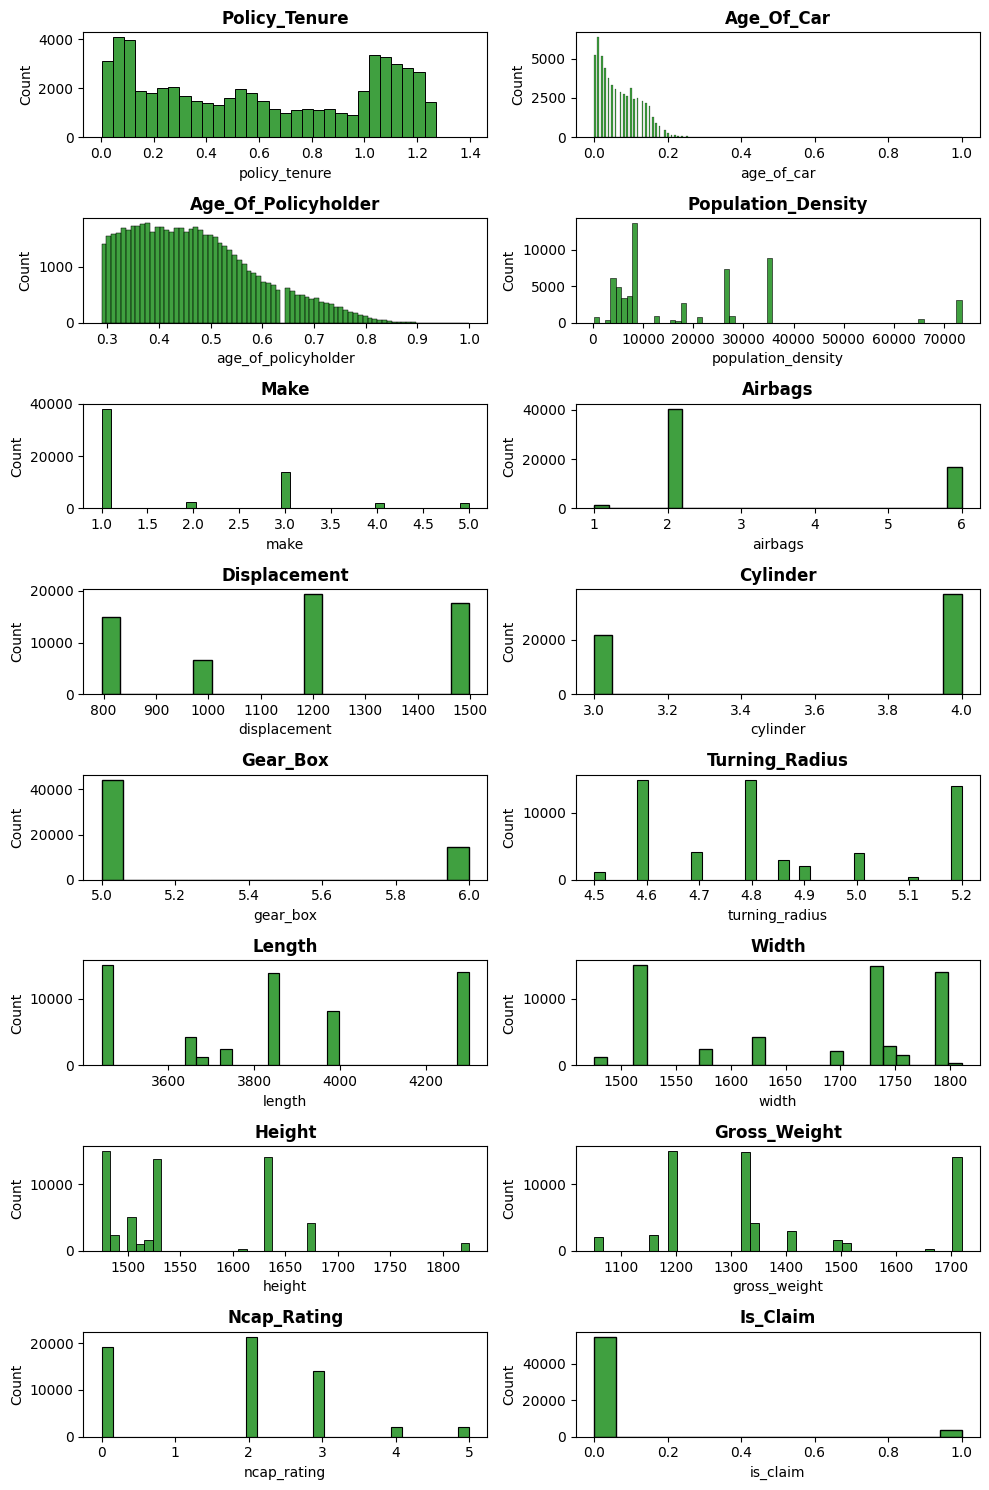

In [14]:
target = [i for i in numerical.columns]
plt.figure(figsize=(10,15))
for n,column in enumerate(target):
    plot=plt.subplot(8,2,n+1)
    sns.histplot(train_df[column],color='green')
    plt.title(f'{column.title()}',weight='bold')
    plt.tight_layout()

### - Categorical Features

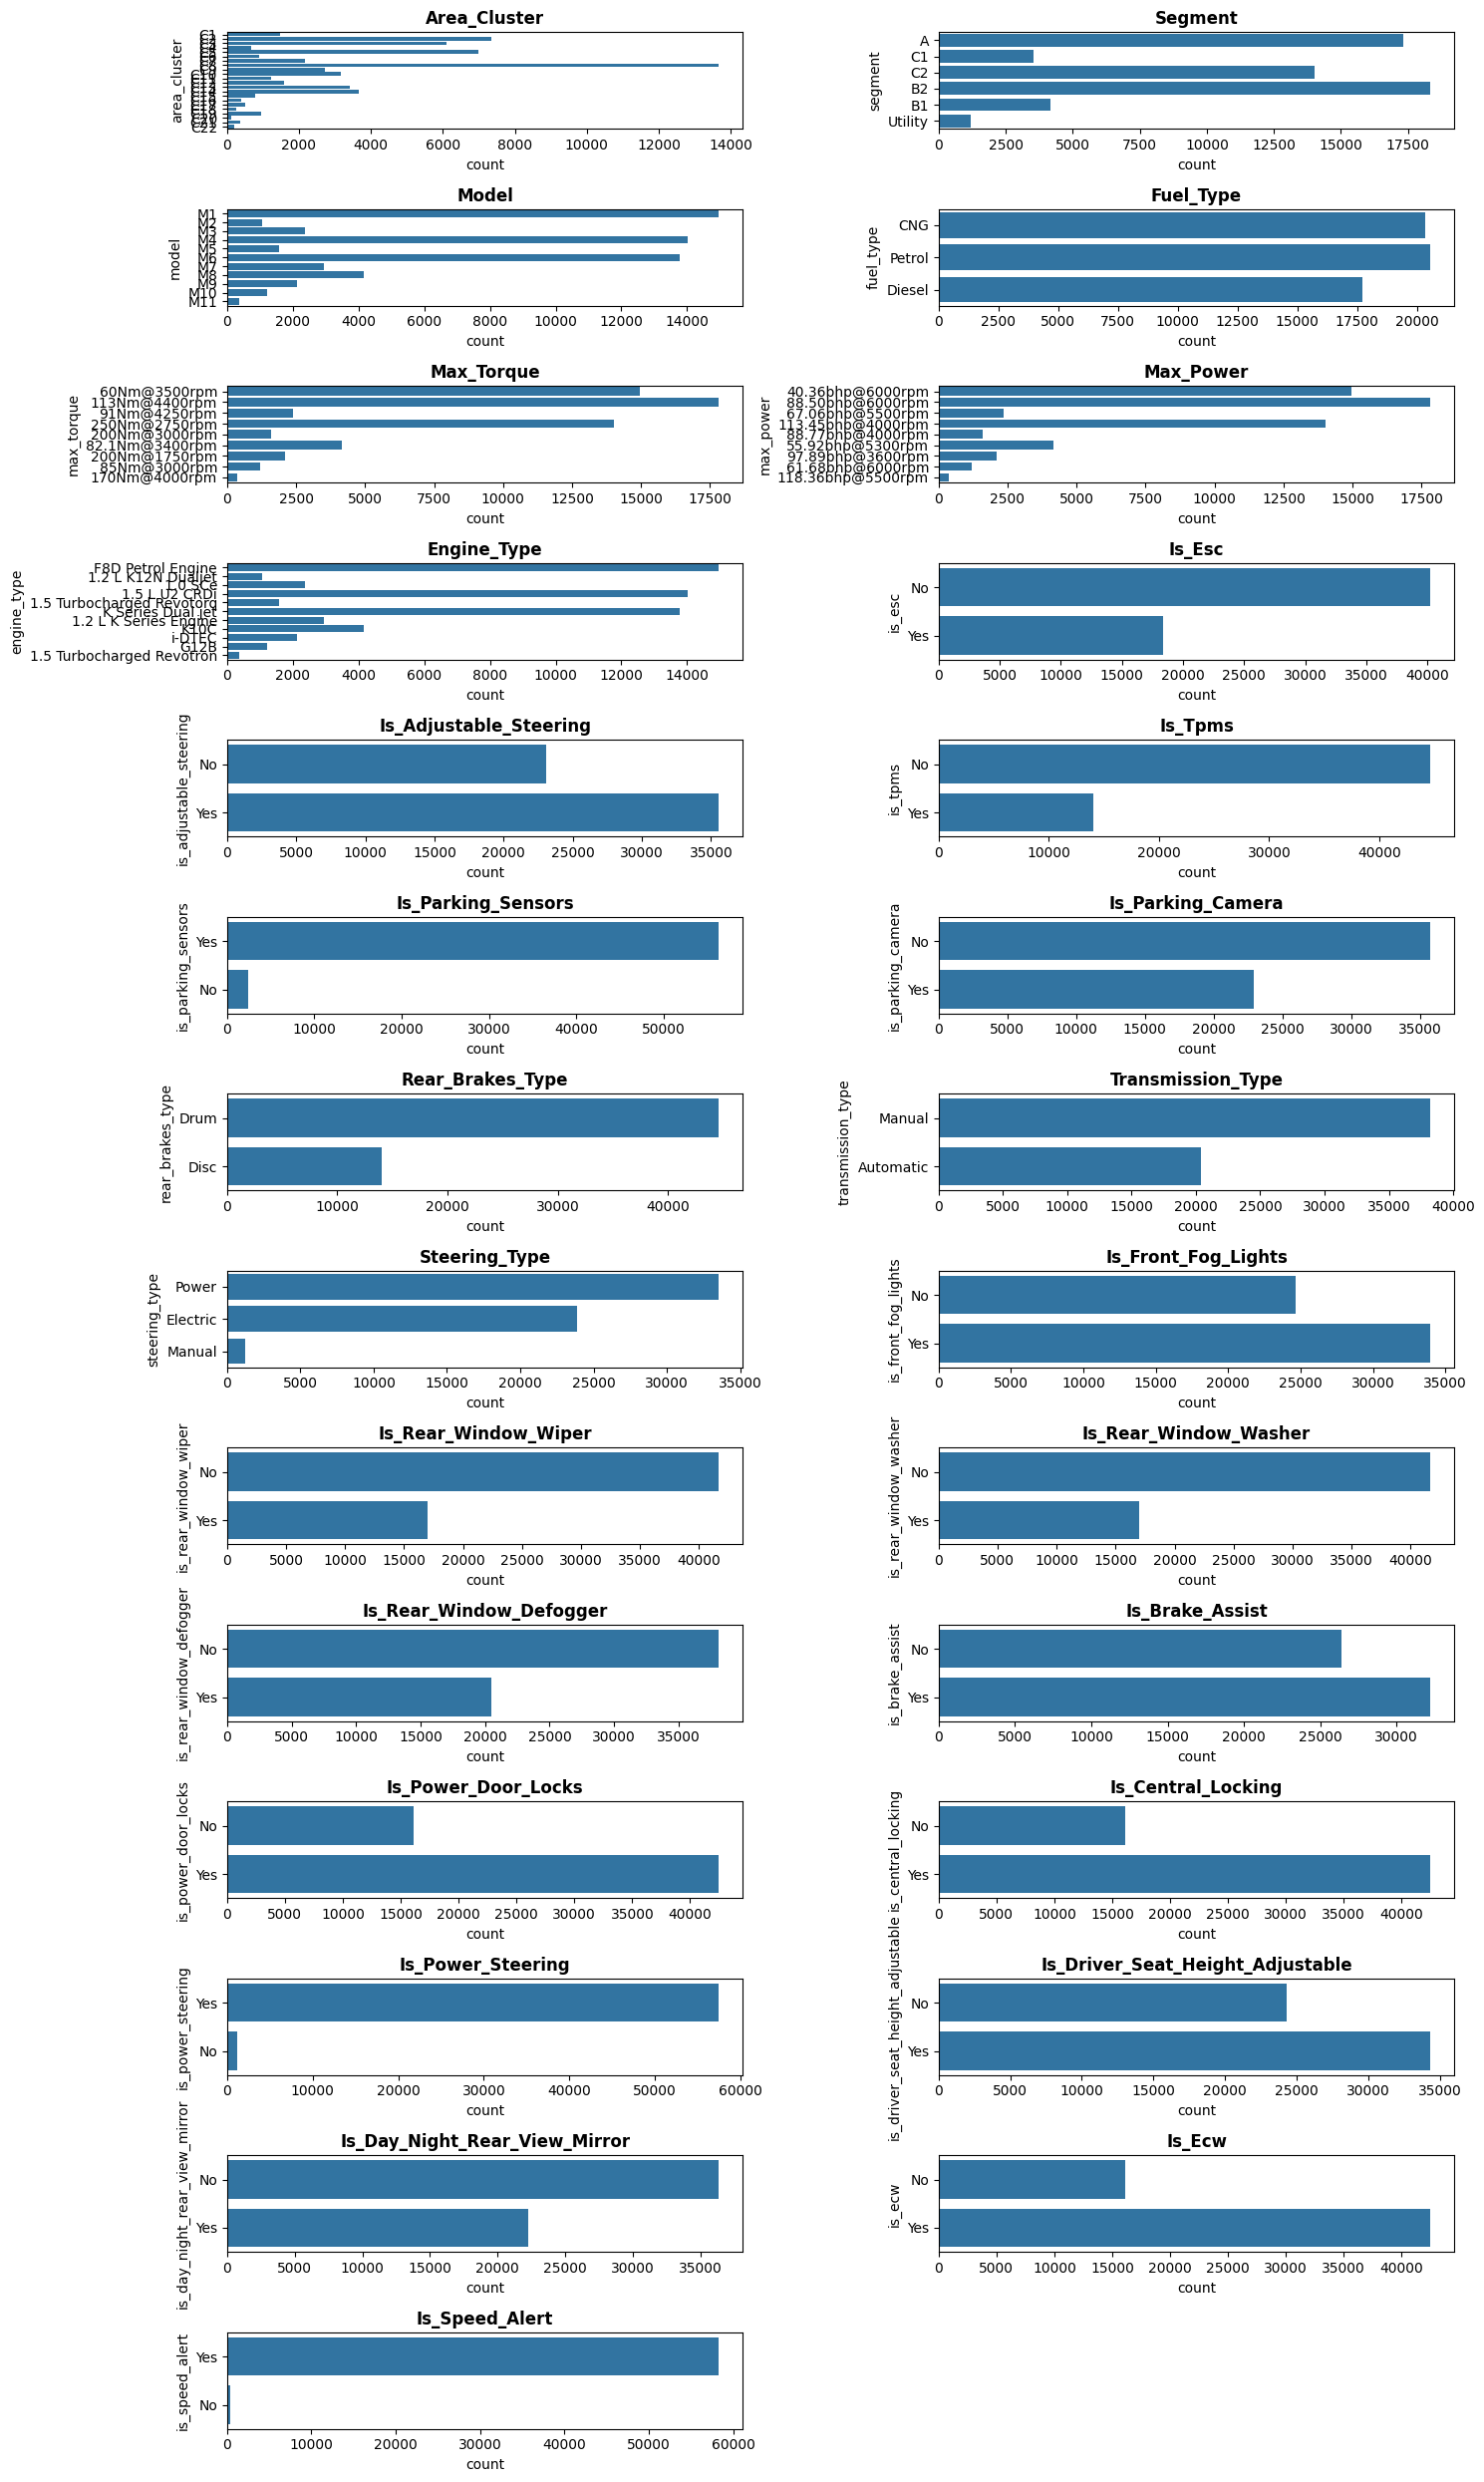

In [15]:
categorical=categorical.drop('policy_id',axis=1)

target = [i for i in categorical.columns]
plt.figure(figsize=(15,25))
for n,column in enumerate(target):
    plot=plt.subplot(14,2,n+1)
    sns.countplot(train_df[column])
    plt.title(f'{column.title()}',weight='bold')
    plt.tight_layout()

In [16]:
train_cpy = train_df.copy()
test_cpy = test_df.copy()

In [17]:
train_cpy.drop(['policy_id'], axis=1, inplace=True)
test_cpy.drop(['policy_id'], axis=1, inplace=True)

In [18]:
ordinal_col = ['max_torque', 'max_power', 'transmission_type', 'steering_type']

train_cpy['transmission_type'] = train_cpy['transmission_type'].replace({'Manual' : 1, 'Automatic' : 2})
train_cpy['steering_type'] = train_cpy['steering_type'].replace({'Manual' : 1, 'Power' : 2, 'Electric': 3})

train_cpy[['max_torque_Nm', 'max_torque_rpm']] = train_cpy["max_torque"].apply(lambda x: pd.Series(str(x).split("@")))
train_cpy.drop(["max_torque"], axis=1, inplace= True)
train_cpy['max_torque_Nm'] = train_cpy['max_torque_Nm'].str[:-2].astype(float)
train_cpy['max_torque_rpm'] = train_cpy['max_torque_rpm'].str[:-3].astype(int)



train_cpy[['max_power_bhp', 'max_power_rpm']] = train_cpy["max_power"].apply(lambda x: pd.Series(str(x).split("@")))
train_cpy.drop(["max_power"], axis=1, inplace= True)
train_cpy['max_power_rpm'] = train_cpy['max_power_rpm'].str[:-3].astype(int)
train_cpy['max_power_bhp'] = train_cpy['max_power_bhp'].str[:-3].astype(float)

/tmp/ipykernel_5648/4068152142.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_cpy['transmission_type'] = train_cpy['transmission_type'].replace({'Manual' : 1, 'Automatic' : 2})
/tmp/ipykernel_5648/4068152142.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_cpy['steering_type'] = train_cpy['steering_type'].replace({'Manual' : 1, 'Power' : 2, 'Electric': 3})


In [19]:
test_cpy['transmission_type'] = test_cpy['transmission_type'].replace({'Manual' : 1, 'Automatic' : 2})
test_cpy['steering_type'] = test_cpy['steering_type'].replace({'Manual' : 1, 'Power' : 2, 'Electric': 3})

test_cpy[['max_torque_Nm', 'max_torque_rpm']] = test_cpy["max_torque"].apply(lambda x: pd.Series(str(x).split("@")))
test_cpy.drop(["max_torque"], axis=1, inplace= True)
test_cpy['max_torque_Nm'] = test_cpy['max_torque_Nm'].str[:-2].astype(float)
test_cpy['max_torque_rpm'] = test_cpy['max_torque_rpm'].str[:-3].astype(int)



test_cpy[['max_power_bhp', 'max_power_rpm']] = test_cpy["max_power"].apply(lambda x: pd.Series(str(x).split("@")))
test_cpy.drop(["max_power"], axis=1, inplace= True)
test_cpy['max_power_rpm'] = test_cpy['max_power_rpm'].str[:-3].astype(int)
test_cpy['max_power_bhp'] = test_cpy['max_power_bhp'].str[:-3].astype(float)

/tmp/ipykernel_5648/783489384.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_cpy['transmission_type'] = test_cpy['transmission_type'].replace({'Manual' : 1, 'Automatic' : 2})
/tmp/ipykernel_5648/783489384.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_cpy['steering_type'] = test_cpy['steering_type'].replace({'Manual' : 1, 'Power' : 2, 'Electric': 3})


In [20]:
train_cpy = pd.get_dummies(train_cpy, drop_first=True)
test_cpy = pd.get_dummies(test_cpy,drop_first=True)

In [21]:
X = train_cpy.drop(['is_claim'], axis=1)
y = train_cpy['is_claim']
X_test = test_cpy.copy()

policy_id = test_df['policy_id']

In [22]:
## SMOTE to handle imbalanced data

from imblearn.over_sampling import SMOTE

sm =  SMOTE(random_state=12, sampling_strategy=0.8)

X_sm, y_sm =  sm.fit_resample(X,y)

X_sm.shape, y_sm.shape

from collections import Counter

print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_sm)))

Original dataset shape Counter({0: 54844, 1: 3748})
Resampled dataset shape Counter({0: 54844, 1: 43875})


## Train and Test Split

In [23]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X_sm,y_sm,test_size = 0.2, random_state = 42)

In [24]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score,f1_score

## Model Building
Takes some time, approx 1 - 2 minutes.

In [25]:
dt=RandomForestClassifier(n_estimators=1000,
                         criterion='gini',
                         max_depth=12,
                         max_features='log2',
                         min_samples_leaf=1,
                         min_samples_split=5,
                         random_state=42)

# Train Model
dt.fit(X_train,y_train)

# Training set performance
train_accuracy= dt.score(X_train,y_train)

#Testing set performance
test_accuracy=dt.score(X_test,y_test)


print('Accuracy for Training set is')
print( 100*train_accuracy)
print('----------------------------------')
print('Accuracy for Testing set is')
print( 100*test_accuracy)

Accuracy for Training set is
74.19436530547642
----------------------------------
Accuracy for Testing set is
72.18901944894651


In [26]:
pred = dt.predict(X_test)

## Model Evaluation

In [27]:
from sklearn.metrics import classification_report

print(f1_score(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

0.6727066817667045


              precision    recall  f1-score   support

           0       0.74      0.78      0.76     11028
           1       0.70      0.65      0.67      8716

    accuracy                           0.72     19744
   macro avg       0.72      0.71      0.72     19744
weighted avg       0.72      0.72      0.72     19744



## Predict Test Data

In [28]:
y_pred=dt.predict(X_test)

In [29]:
y_pred


array([1, 0, 0, ..., 0, 1, 0])